# Reproducible Environmental Observations and Analysis

**Author**: Daniel Nüst

## Introduction

This document showcases a completely reproducible [particulate](https://en.wikipedia.org/wiki/Particulates) matter analysis.
Starting from the used measurement devices, via software for data hosting, to the analysis and visualisation environment.
It stands on the shoulders of communities who provide free and open resources in the spirit of [Open Science](https://en.wikipedia.org/wiki/Open_science):

- **open hardware**: the [senseBox](https://sensebox.de/en/) project
- **open data**: the [openSenseMap](https://opensensemap.org/) and it's [API](https://api.opensensemap.org/) provide environmental data licensed under [PDDL 1.0](http://opendatacommons.org/licenses/pddl/summary/)
- **free and open source software**: [software by the senseBox team](https://github.com/sensebox/) to host their services and [download the data into R](https://github.com/noerw/opensensmapR), [R](https://jupyter.org/) with a large number of packages (e.g. `rmarkdown`, `sf`, `dplyr`, ...), [Project Jupyter](https://jupyter.org/), [binder](https://mybinder.org/), [Rocker](https://www.rocker-project.org/), [Docker](https://docker.com/), ... and many more

The actual analysis is based on the [opensensmapR vignette `osem-intro`](https://noerw.github.io/opensensmapR/inst/doc/osem-intro.html).
The code and it's environment are published, documented, and packaged to support [reproducible research](https://doi.org/10.1045/january2017-nuest).

The code repository is [https://github.com/nuest/sensebox-binder](https://github.com/nuest/sensebox-binder) and the [git version hash](https://git-scm.com/docs/git-rev-parse) is .
The repository can be opened interactively at [http://mybinder.org/v2/gh/nuest/sensebox-binder/master](http://mybinder.org/v2/gh/nuest/sensebox-binder/master).
The code (this document as either [R Markdown](http://rmarkdown.rstudio.com/) or [Jupyter Notebook](https://nbformat.readthedocs.io/en/latest/)) and environment (a [Docker image](https://docs.docker.com/glossary/?term=image)) are archived with a [DOI](https://www.doi.org/): [`10.5281/zenodo.1135140`](https://doi.org/10.5281/zenodo.1135140).

**Note**: The data is not included in the archive so this document can only be compiled as long as the openSenseMap API exists.

## Analysis

In the remainder of this file, code "chunks" and text are [interspersed](https://en.wikipedia.org/wiki/Literate_programming) to provide a transparent and understandable workflow.
All code is shown, but output is sometimes hidden for the sake of clarity.
The analysis of takes a look at _fine particulate matter measured in Germany at New Year's Eve 2018_.

### Load required software

In [30]:
library("opensensmapr")
library("dplyr")
library("lubridate")
library("units")
library("sf")

### Exploring openSenseMap

In [31]:
all_boxes <- osem_boxes()
analysis_date <- lubridate::as_datetime("2018-01-01 00:00:00")
pm25_boxes <- osem_boxes(
  exposure = 'outdoor',
  date = analysis_date, # ±4 hours
  phenomenon = 'PM2.5',
  model = "homeWifiFeinstaub" # redundant because of phenomenon
)

cat("\n\nThe openSenseMap currently provides access to", nrow(all_boxes), 
    "senseBoxes of which", 
    nrow(pm25_boxes), 
    "provide measurements of PM2.5\n")



The openSenseMap currently provides access to 1089 senseBoxes of which 35 provide measurements of PM2.5


The following map shows the [PM2.5](https://www.umweltbundesamt.de/sites/default/files/medien/377/dokumente/infoblatt_feinstaub_pm2_5_en.pdf) sensor locations.

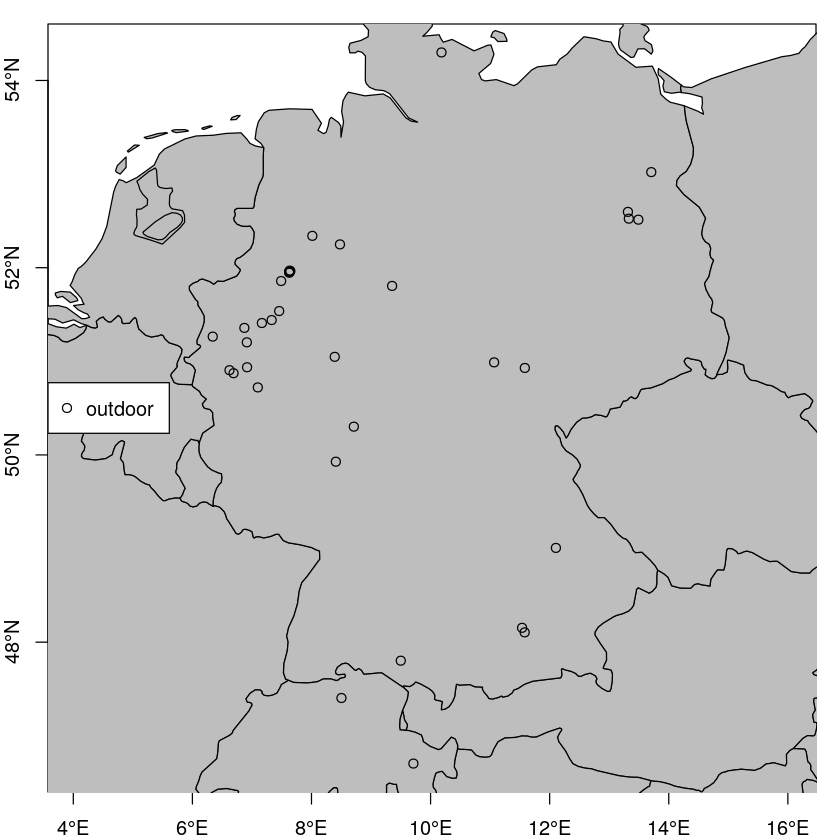

In [32]:
plot(pm25_boxes)

### Particulates at New Year's Eve in Münster

_How many senseBoxes in Münster measure PM2.5 and what are the values?_

In [33]:
ms <- st_sfc(st_point(c(7.62571, 51.96236)))
st_crs(ms) <- 4326

pm25_boxes_sf <- st_as_sf(pm25_boxes, remove = FALSE, agr = "identity")
names(pm25_boxes_sf) <- c(names(pm25_boxes), "geometry")

pm25_boxes_sf <- cbind(pm25_boxes_sf, dist_to_ms = st_distance(ms, pm25_boxes_sf))
max_dist <- set_units(3, km) # km from city center

ms_sensors <- pm25_boxes_sf[pm25_boxes_sf$dist_to_ms < max_dist,c("X_id", "name")]
ms_sensors

,X_id,name,geometry
6,591f578c51d34600116a8ea5,Wetterstation Erpho,POINT (7.645218 51.96422)
20,59c3b5e1d67eb50011335cee,Gruenes_Zentrum,POINT (7.633289 51.956907)
21,59c67b5ed67eb50011666dbb,kartoffelsalat,POINT (7.62677 51.946322)
28,5a0587159fd3c200118eaaf6,Münster nachhaltig e.V.,POINT (7.624276 51.955196)
33,5a2e6b9037b73700105ea907,Gefängnisblick,POINT (7.633041 51.968728)


Now we retrieve data for 5 senseBoxes with values in the area of interest.

In [34]:
class(ms_sensors) <- c(class(ms_sensors), "sensebox")
ms_data <- osem_measurements(ms_sensors, phenomenon = "PM2.5", 
                             from = lubridate::as_datetime("2017-12-31 20:00:00"),
                             to = lubridate::as_datetime("2018-01-01 04:00:00"))

cat("\nMeasurement count:", nrow(ms_data))


Measurement count: 2512

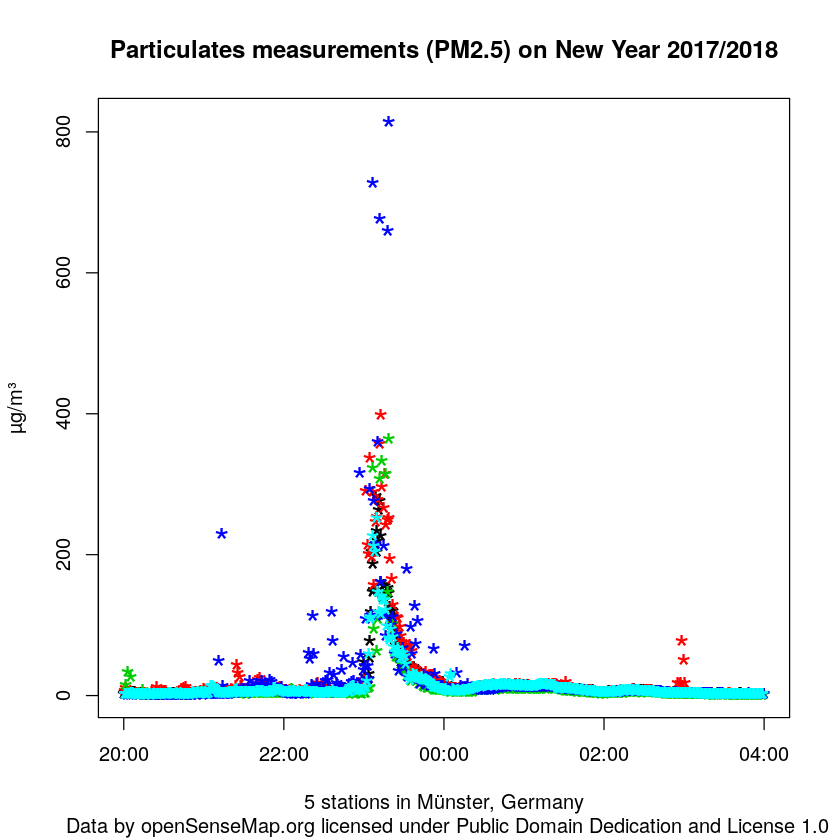

In [35]:
plot(value~createdAt, ms_data, 
     type = "p", pch = '*', cex = 2, # new year's style
     col = factor(ms_data$sensorId), 
     xlab = NA, 
     ylab = unique(ms_data$unit),
     main = "Particulates measurements (PM2.5) on New Year 2017/2018",
     sub = paste(nrow(ms_sensors), "stations in Münster, Germany\n",
                 "Data by openSenseMap.org licensed under",
                 "Public Domain Dedication and License 1.0"))

You can see, it was a [very "particular" celebration](http://www.dw.com/en/new-years-eve-are-fireworks-harming-the-environment/a-41957523).

_Who is the record holder?_

In [36]:
ms_data %>% arrange(desc(value)) %>% head(n = 3)

value,createdAt,lon,lat,sensorId,unit
815.0,2017-12-31 23:18:45,7.633041,51.96873,5a2fe63775a96c000fea9148,µg/m³
727.6,2017-12-31 23:06:45,7.633041,51.96873,5a2fe63775a96c000fea9148,µg/m³
677.7,2017-12-31 23:11:45,7.633041,51.96873,5a2fe63775a96c000fea9148,µg/m³


**Note:** The timestamp is UTC and the local time is [CET](https://en.wikipedia.org/wiki/CET) (`UTC+1:00`).

In [37]:
# find the top station by its coordinates
# find the top station by its coordinates
top_sensor <- ms_data %>% arrange(desc(value)) %>% head(n = 1) %>% .$sensorId
top_box_coords <- ms_data %>% filter(sensorId == top_sensor) %>% select("lat", "lon") %>% slice(c(1))
top_box <- all_boxes %>% filter(lon == top_box_coords$lon, lat == top_box_coords$lat)

cat("\nTop sensor: ", top_sensor, "\n",
    "Top box: ", top_station$name, "\n", sep = "")

ERROR: Error in cat("\nTop sensor: ", top_sensor, "\n", "Top box: ", top_station$name, : object 'top_station' not found


Congratulations (?) the top box **Gefängnisblick** for holding the record values just after the new year started.

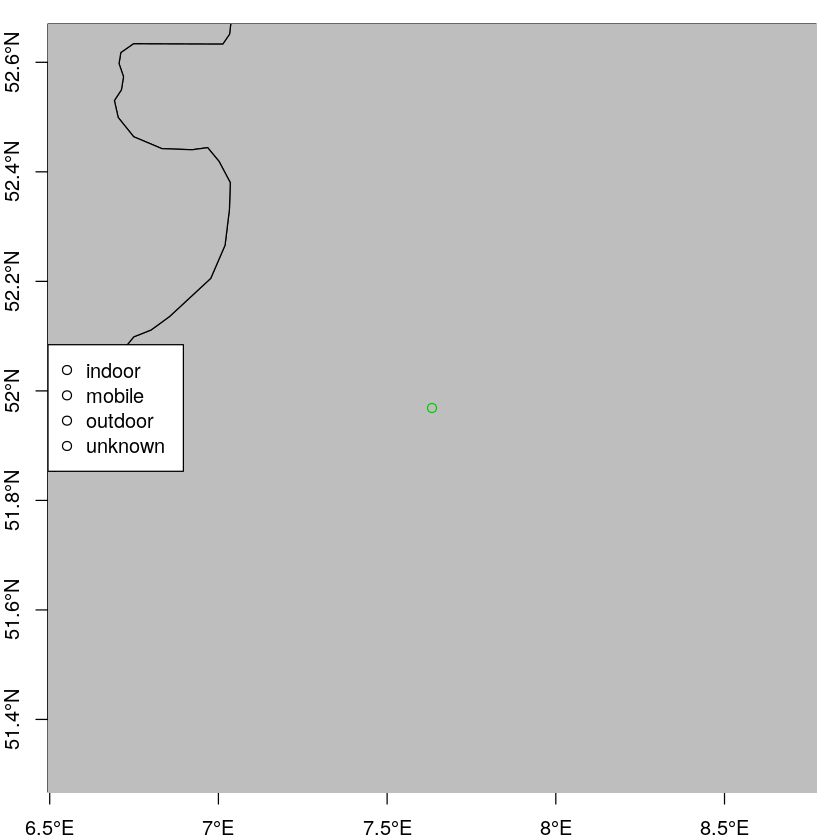

In [38]:
# TODO leaflet map, https://github.com/ellisonbg/ipyleaflet
plot(top_box)

## Conclusion

This document creates a reproducible workflow of open data from a public API.
It leverages software to create a transparent analysis, which can be easily opened, investigated, and even developed further with a web browser by opening the public code repository on a free cloud platform.
To increase reproducibility, the data is cached manually as CSV files (i.e. text-based data format) and stored next to the analysis file.
A use may adjust this workflow to her own needs, like different location or time period, by adjust the R code and deleting the data files.
In case the exploration platform ceases to exist, users may still recreate the environment themselves based on the files in the code repository.
A snapshot of the files from the code repository, i.e. data, code, and runtime environment (as a Docker image) are stored in a reliable data repository.
While the manual workflow of building the image and running it is very likely to work in the future, the archived image captures the exact version of the software the original author used.

The presented solution might seem complex.
But it caters to many different levels of expertise (one-click open in browser vs. self-building of images and local inspection) and has several fail-safes (binder may disappear, GitHub repository may be lost, Docker may stop working).
The additional work is much outweighed by the advantages in transparency and openness.

## License

<img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />

This document is licensed under a [Creative Commons Attribution 4.0 International ](https://creativecommons.org/licenses/by/4.0/) (CC BY 4.0).

## Metadata

In [39]:
sessionInfo()

R version 3.4.2 (2017-09-28)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 9 (stretch)

Matrix products: default
BLAS/LAPACK: /usr/lib/libopenblasp-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2       maps_3.2.0         leaflet_1.1.0      sf_0.5-4          
[5] units_0.4-6        lubridate_1.7.0    dplyr_0.7.4        opensensmapr_0.3.1

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.13         compiler_3.4.2       bindr_0.1           
 [4] tools_3.4.2          digest_0.6.12        uuid_0.1-